In [1]:
# Necessary channels: P7/3/z/4/8, PO-9/10, and O-1/z/2б 23:32
# channels = ['P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

In [2]:
# raw_data
# we have n = 100 trials for each subject in one session
# time intervals is time_interval = 0 to 4000 ms
# sampling frequences is fs = 1000 Hz
# we have 4000 data points, since we sample 0-4000 ms interval with 1000 Hz, i.e. each 1 ms
# therefore, smt has dimensions 4000x100x62, 4000 data points x 100 trials x 62 electrodes

# preprocessing for ssvep analysis
# sampling frequence is fs = 100 HZ
# once more we sample raw 4000 data points with 100 Hz, i.e. each 10 ms
# thus, we have 400 data points
# filtered smt for ssvep would have 400x100x10 dimensions

In [3]:
# we have reference signals Yi for each fi
# marker = {'1','up';'2', 'left';'3', 'right';'4', 'down'};
# nClasses = 4;
# freq = 60./[5, 7, 9, 11];
# fs = 100;
# time = 4;

# t= 0:1/fs:time;
# Y = cell(1,nClasses); # list of 4 lists
# r = cell(1,nClasses); # list of 4 lists


# for each trial_data, 400x10 dimension
#   do cca_analysis {
#       for each class (4 classes):
#           r = canoncorr(trial_data, Yi)  it should be 1xd vector
#           r = max(r)
#   }
#       

In [4]:
from sklearn.cross_decomposition import CCA
import numpy as np

In [5]:
def get_max_cca_corr(X, Y):
    cca = CCA(n_components=1)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=1).max()
    return corr

In [6]:
def get_cca_corrs(X, Y_ref):
    r = []
    for i in range(len(Y_ref)):
        r.append(get_max_cca_corr(X, Y_ref[i]))
    return r

In [7]:
def generate_ref_signals(num_classes, freqs, fs, end_time):
    t = np.linspace(0, end_time-1/fs, fs*end_time)
    ref_signals = []
    for i in range(num_classes):
        ref = 2*np.pi*freqs[i]*t
        ref_signals.append(np.array([np.sin(ref), np.cos(ref), np.sin(2*ref), np.cos(2*ref)]).T)
    return ref_signals

In [8]:
def ssvep_preprocess(data_x, data_t, start, end, fs, channels, show):
    # segmented data shape:  trials x data_points x channels
    segmented_data = np.zeros((len(data_t), end-start, len(channels)))
    for i in range(len(data_t)):
        segmented_data[i] = data_x[(data_t[i]+start):(data_t[i]+end), channels]
    period = int(1000/fs)
    downsampled_data = segmented_data[:,::period,:]

    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(downsampled_data[0,:20,2])
        plt.plot(downsampled_data[0,:20,7])
        plt.grid('on')
        plt.legend(['Channel Pz', 'Channel Oz'])
        plt.show()
    return downsampled_data

In [9]:
def get_ssvep_features(data, t, num_classes=4, freqs=60/np.array([5,7,9,11]), fs=100, end_time=4, show=False):
    """
    default parameters:
    num_classes=4, freqs=60/np.array([5,7,9,11]), fs=100, end_time=4

    input: data
    output: canonical correlation p values between data and ref signals at individual freqs
    """
    channels = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
    data = ssvep_preprocess(data_x=data, data_t=t, start=0, end=4000, fs=100, channels=channels, show=show)
    Y_refs = generate_ref_signals(num_classes, freqs, fs, end_time)

    p = []
    trials = data.shape[0]
    for i in range(trials):
        p.append(get_cca_corrs(data[i], Y_refs))
    return np.array(p)

In [10]:
import os
from google.colab import drive
from scipy.io import loadmat

In [11]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/BCI')

Mounted at /content/drive


In [12]:
def load_data(ses, sub, par):
    # example: 'data/session1/s1/sess01_subj01_EEG_ERP.mat'
    if len(str(sub))>1:
      filepath = f'data/session{ses}/s{sub}/sess0{ses}_subj{sub}_EEG_{par}.mat'
    else:  
      filepath = f'data/session{ses}/s{sub}/sess0{ses}_subj0{sub}_EEG_{par}.mat'

    train_data = loadmat(filepath)[f'EEG_{par}_train'][0][0]
    test_data = loadmat(filepath)[f'EEG_{par}_test'][0][0]
    return train_data, test_data

def select_trials(data_t, data_y, num_trials=100):
    sampled_indices = np.random.choice(len(data_t[0]), num_trials, replace=False)
    return data_t[0][sampled_indices], data_y[0][sampled_indices]

def get_data_xyt(train_data, test_data):
    train_t, train_y = select_trials(train_data['t'], train_data['y_dec'], 100)
    test_t, test_y = select_trials(test_data['t'], test_data['y_dec'], 100)
    test_t += train_data['x'].shape[0]  # due to concatenation

    data_x = np.concatenate((train_data['x'], test_data['x']))
    data_y = np.concatenate((train_y, test_y))
    data_t = np.concatenate((train_t, test_t))
    return data_x, data_y, data_t

In [13]:
def evaluate(features, labels):
    out = np.zeros(len(labels))
    for i in range(len(labels)):
        out[i] = np.argmax(features[i]) + 1
    count = 0
    for y, y_hat in zip(labels, out):
        if y == y_hat:
            count += 1
    return count/len(labels)

In [14]:
def main_loop(sessions, subjects, paradigms):
    accuracy = {}
    for ses in sessions:
        accuracy[ses] = {}
        for sub in subjects:
            accuracy[ses][sub] = {}
            for par in paradigms:
                train_data, test_data = load_data(ses, sub, par)
                data_x, data_y, data_t = get_data_xyt(train_data, test_data)
                ssvep_features = get_ssvep_features(data_x, data_t)
                acc = evaluate(ssvep_features, data_y)
                accuracy[ses][sub][par] = acc
                print(f'session: {ses}, subject: {sub}, paradigm: {par}, accuracy: {acc}')
    return accuracy

sessions =  ['1', '2']
subjects = [str(i) for i in range(1, 21)]
paradigms = ['SSVEP']

accuracies = main_loop(sessions, subjects, paradigms)                

session: 1, subject: 1, paradigm: SSVEP, accuracy: 0.96


/usr/local/lib/python3.6/dist-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


session: 1, subject: 2, paradigm: SSVEP, accuracy: 0.99
session: 1, subject: 3, paradigm: SSVEP, accuracy: 0.865
session: 1, subject: 4, paradigm: SSVEP, accuracy: 1.0
session: 1, subject: 5, paradigm: SSVEP, accuracy: 0.81
session: 1, subject: 6, paradigm: SSVEP, accuracy: 0.985
session: 1, subject: 7, paradigm: SSVEP, accuracy: 1.0
session: 1, subject: 8, paradigm: SSVEP, accuracy: 0.755
session: 1, subject: 9, paradigm: SSVEP, accuracy: 0.9
session: 1, subject: 10, paradigm: SSVEP, accuracy: 0.92
session: 1, subject: 11, paradigm: SSVEP, accuracy: 1.0
session: 1, subject: 12, paradigm: SSVEP, accuracy: 1.0
session: 1, subject: 13, paradigm: SSVEP, accuracy: 0.845
session: 1, subject: 14, paradigm: SSVEP, accuracy: 0.975
session: 1, subject: 15, paradigm: SSVEP, accuracy: 0.98
session: 1, subject: 16, paradigm: SSVEP, accuracy: 1.0
session: 1, subject: 17, paradigm: SSVEP, accuracy: 0.95
session: 1, subject: 18, paradigm: SSVEP, accuracy: 0.985
session: 1, subject: 19, paradigm: SSVE

In [15]:
import matplotlib.pyplot as plt
num_classes=4
freqs=60/np.array([5,7,9,11])
fs=100
end_time=4
sample_ref_signals = generate_ref_signals(num_classes, freqs, fs, end_time)

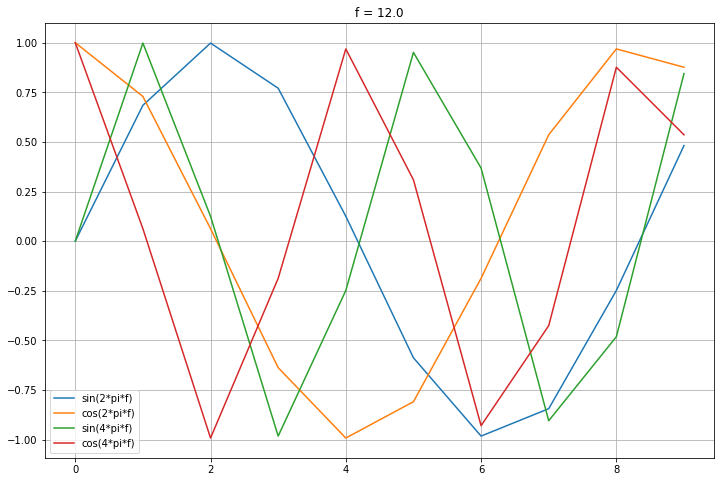

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(10), sample_ref_signals[0][:10])
plt.grid('on')
plt.title(f'f = {freqs[0]}')
plt.legend(['sin(2*pi*f)', 'cos(2*pi*f)', 'sin(4*pi*f)', 'cos(4*pi*f)'])
plt.show()

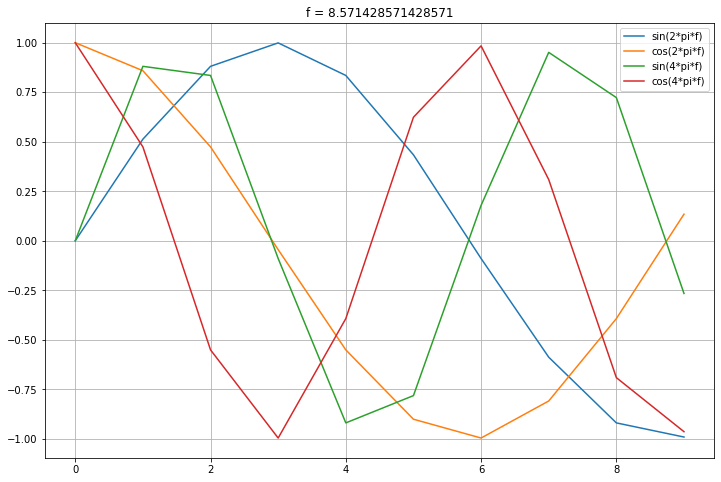

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(10), sample_ref_signals[1][:10])
plt.grid('on')
plt.title(f'f = {freqs[1]}')
plt.legend(['sin(2*pi*f)', 'cos(2*pi*f)', 'sin(4*pi*f)', 'cos(4*pi*f)'])
plt.show()

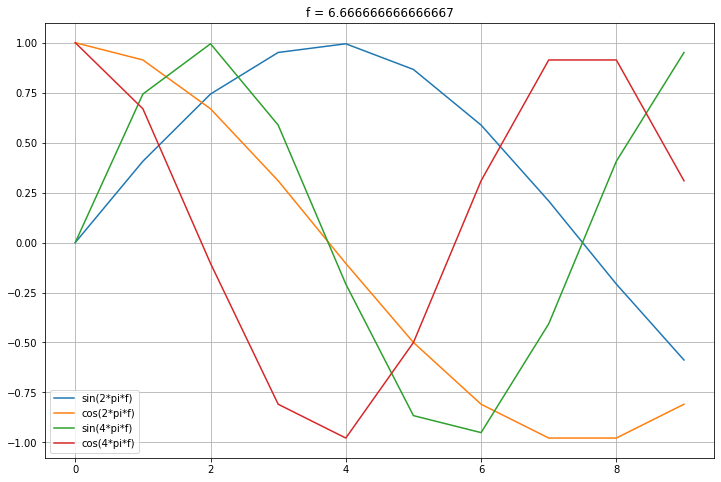

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(range(10), sample_ref_signals[2][:10])
plt.grid('on')
plt.title(f'f = {freqs[2]}')
plt.legend(['sin(2*pi*f)', 'cos(2*pi*f)', 'sin(4*pi*f)', 'cos(4*pi*f)'])
plt.show()

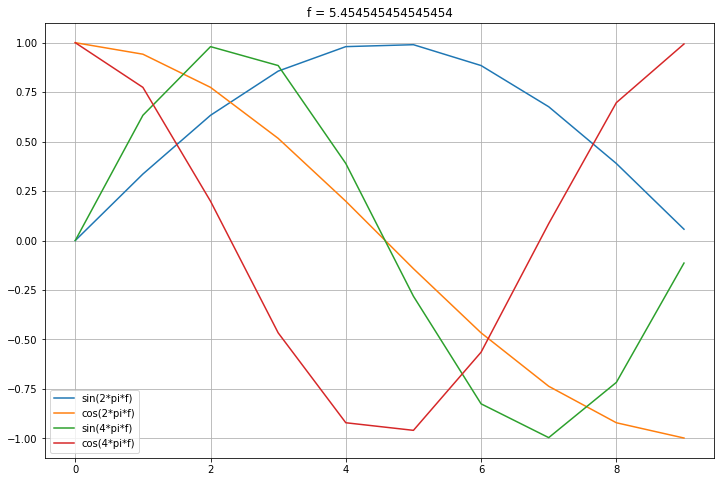

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(range(10), sample_ref_signals[3][:10])
plt.grid('on')
plt.title(f'f = {freqs[3]}')
plt.legend(['sin(2*pi*f)', 'cos(2*pi*f)', 'sin(4*pi*f)', 'cos(4*pi*f)'])
plt.show()

Session 1, Subject 1, SSVEP Trial 1


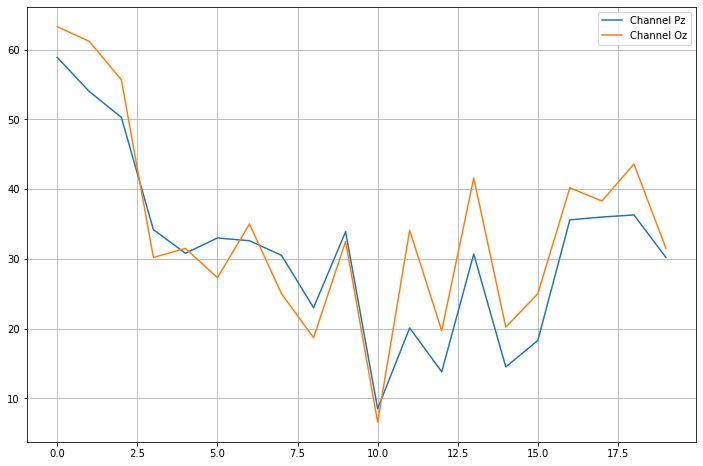

Result of SSVEP Preprocesssing:  [0.15841487 0.18408251 0.2937486  0.44204379]
Output would be:  3


In [ ]:
train_data, test_data = load_data('1', '1', 'SSVEP')
data_x, data_y, data_t = get_data_xyt(train_data, test_data)
print('Session 1, Subject 1, SSVEP Trial 1')
ssvep_features = get_ssvep_features(data_x, data_t, show=True)
print('Result of SSVEP Preprocesssing: ', ssvep_features[0])
print('Output would be: ', np.argmax(ssvep_features[0]))